In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import copy
import math
import sys
import time
import random

import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.max_mol = 11100
args.max_peaks = 150
args.max_atoms = 250
args.max_partial_charge = 4.0
args.min_partial_charge = -1.0
args.max_intensity = 1000
args.min_intensity = 0
args.max_shift = 20
args.min_shift = -3
args.resolution = 10
args.num_feature = 59
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = False

In [4]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# 1. Pre-Processing

In [5]:
def read_nmrDB_pickle(file_name, num_mol, max_peak):    
    df = pd.read_pickle(file_name)
    df = df.head(num_mol)
    df = df.sample(frac=1).reset_index(drop=True)
    
    inchi_list = df['inchi'].tolist()
    peaks_list = df['peaks'].tolist()
    
    for i, inchi in enumerate(inchi_list):
        if '\n' in inchi:
            inchi_list[i] = inchi.split('\n')[0]
    
    inchi_list_final = list()
    shift_list = list()
    intensity_list = list()
    num_peak_list = list()
    for idx, peaks in enumerate(peaks_list):
        isValid = True
        shifts = list()
        intensities = list()
        for i, peak in enumerate(peaks):
            shifts.append(float(peak[1]))
            intensities.append(float(peak[2]))
            if intensities[i] < 0:
                isValid = False
        if sum(intensities) == 0:
            isValid = False
        if isValid:
            shift_list.append(shifts)
            intensity_list.append(intensities)
            num_peak_list.append(len(peaks))
            inchi_list_final.append(inchi_list[idx])
        
    return inchi_list_final, shift_list, intensity_list, num_peak_list

def convert_to_distribution(list_shift, list_intensity, resolution):
    list_distribution = list()
    
    for i in range(len(list_shift)):
        distribution = [0] * resolution
        scope = (args.max_shift-args.min_shift)/resolution

        for j in range(len(list_shift[i])):
            shift = list_shift[i][j]
            intensity = list_intensity[i][j]
            idx = int((shift-args.min_shift)/scope)
            distribution[idx] += intensity
        total_prob = sum(distribution)
        distribution = [ prob/total_prob for prob in distribution ]
        
        list_distribution.append(distribution)
    
    return np.asarray(list_distribution)

def convert_inchi_to_graph(inchi_list, max_atoms, num_feature):
    adj = list()
    adj_norm = list()
    features = list()
    for inchi in inchi_list:
        # Generate mol from InChI code.
        iMol = Chem.inchi.MolFromInchi(inchi)
        # Add H atoms to the mol.
        iMol = Chem.rdmolops.AddHs(iMol)
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        if (iAdjTmp.shape[0] <= max_atoms):
            # Preprocess features
            iFeature = np.zeros((max_atoms, num_feature))
            iFeatureTmp = []
            AllChem.ComputeGasteigerCharges(iMol)
            for atom in iMol.GetAtoms():
                iFeatureTmp.append(atom_feature(atom))
            iFeature[0:len(iFeatureTmp), 0:num_feature] = iFeatureTmp
            features.append(iFeature)
            # Preprocess adjacency matrix
            iAdj = np.zeros((max_atoms, max_atoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)
    
    return features, adj

def normalized_partial_charge_of_atom(atom):
    partial_charge = float(atom.GetProp("_GasteigerCharge"))
    partial_charge = (partial_charge-args.min_partial_charge)/(args.max_partial_charge-args.min_partial_charge)
    return partial_charge

def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()] +
                    [normalized_partial_charge_of_atom(atom)])    # (40, 6, 5, 6, 1, 1)

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

In [6]:
class NMRDataset(Dataset):
    
    def __init__(self, list_feature, list_adj, list_distribution):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_distribution = list_distribution
        
    def __len__(self):
        return len(self.list_feature)
    
    def __getitem__(self, index):
        feature = self.list_feature[index]
        adj = self.list_adj[index]
        distribution = self.list_distribution[index]
        return feature, adj, distribution
    
def partition(list_feature, list_adj, list_distribution, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)
    
    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    distribution_train = list_distribution[:num_train]
    
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    distribution_val = list_distribution[num_train:num_train + num_val]
    
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    distribution_test = list_distribution[num_total - num_test:]
    
    train_set = NMRDataset(feature_train, adj_train, distribution_train)
    val_set = NMRDataset(feature_val, adj_val, distribution_val)
    test_set = NMRDataset(feature_test, adj_test, distribution_test)
    
    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [41]:
list_inchi, list_shift, list_intensity, list_num_peak = read_nmrDB_pickle('nmrDB_deduplicated.pkl', 11000, args.max_peaks)
list_feature, list_adj = convert_inchi_to_graph(list_inchi, args.max_atoms, args.num_feature)

In [42]:
list_distribution = convert_to_distribution(list_shift, list_intensity, args.resolution)
dict_partition = partition(list_feature, list_adj, list_distribution, args)

In [9]:
count = 0
for intensities in list_intensity:
    for intensity in intensities:
        if intensity <= 0:
            count += 1
count

10

# 2. Model Construction

$$D_{KL}(P||Q) = -\sum_i P(i)log(\frac{Q(i)}{P(i)})$$
$P$: target distribution  
$Q$: input distribution

In [10]:
def myKLDivLoss(inputs, targets):
    log_targets = torch.log(targets)
    loss = torch.add(log_targets, torch.neg(inputs))
    loss = torch.mul(targets, loss)
    loss[loss==float("Inf")] = 0
    loss[loss!=loss] = 0
    return torch.sum(loss)/len(inputs)

In [11]:
def myKLDiv(inputs, targets):
    log_targets = torch.log(targets)
    loss = torch.add(log_targets, torch.neg(inputs))
    loss = torch.mul(targets, loss)
    loss[loss==float("Inf")] = 0
    loss[loss!=loss] = 0
    return torch.sum(loss, 1)

In [12]:
a = torch.randn(128, 100)
b = torch.randn(128, 100)
myKLDiv(a, b).shape

torch.Size([128])

In [13]:
class SkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        out = in_x + out_x
        return out

In [14]:
class GatedSkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out
            
    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)

In [15]:
class Attention(nn.Module):
    
    def __init__(self, in_dim, output_dim, num_head):
        super(Attention, self).__init__()
        
        self.num_head = num_head
        self.atn_dim = output_dim // num_head
        
        self.linears = nn.ModuleList()
        self.corelations = nn.ParameterList()
        for i in range(self.num_head):
            self.linears.append(nn.Linear(in_dim, self.atn_dim))
            corelation = torch.FloatTensor(self.atn_dim, self.atn_dim)
            nn.init.xavier_normal_(corelation)
            self.corelations.append(nn.Parameter(corelation))
            
        self.tanh = nn.Tanh()
        
    def forward(self, x, adj):
        heads = list()
        for i in range(self.num_head):
            x_transformed = self.linears[i](x)
            alpha = self.attention_matrix(x_transformed, self.corelations[i], adj)
            x_head = torch.matmul(alpha, x_transformed)
            heads.append(x_head)
        output = torch.cat(heads, dim=2)
        return output
            
    def attention_matrix(self, x_transformed, corelation, adj):
        x = torch.einsum('akj,ij->aki', (x_transformed, corelation))
        alpha = torch.matmul(x, torch.transpose(x_transformed, 1, 2))
        alpha = torch.mul(alpha, adj)
        alpha = self.tanh(alpha)
        return alpha

In [16]:
class GCNLayer(nn.Module):
    
    def __init__(self, in_dim, out_dim, n_atom, act=None, bn=False, atn=False, num_head=1, dropout=0):
        super(GCNLayer, self).__init__()
        
        self.use_bn = bn
        self.use_atn = atn
        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.xavier_normal_(self.linear.weight)
        self.bn = nn.BatchNorm1d(n_atom)
        self.attention = Attention(out_dim, out_dim, num_head)
        self.activation = act
        self.dropout_rate = dropout
        self.dropout = nn.Dropout2d(self.dropout_rate)
        
    def forward(self, x, adj):
        out = self.linear(x)
        if self.use_atn:
            out = self.attention(out, adj)
        else:
            out = torch.matmul(adj, out)
        if self.use_bn:
            out = self.bn(out)
        if self.activation != None:
            out = self.activation(out)
        if self.dropout_rate > 0:
            out = self.dropout(out)
        return out, adj

In [17]:
class GCNBlock(nn.Module):
    
    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, atn=True, num_head=1, sc='gsc', dropout=0):
        super(GCNBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(n_layer):
            self.layers.append(GCNLayer(in_dim if i==0 else hidden_dim,
                                        out_dim if i==n_layer-1 else hidden_dim,
                                        n_atom,
                                        nn.ReLU() if i!=n_layer-1 else None,
                                        bn,
                                        atn,
                                        num_head,
                                        dropout))
        self.relu = nn.ReLU()
        if sc=='gsc':
            self.sc = GatedSkipConnection(in_dim, out_dim)
        elif sc=='sc':
            self.sc = SkipConnection(in_dim, out_dim)
        elif sc=='no':
            self.sc = None
        else:
            assert False, "Wrong sc type."
        
    def forward(self, x, adj):
        residual = x
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i==0 else out), adj)
        if self.sc != None:
            out = self.sc(residual, out)
        out = self.relu(out)
        return out, adj

In [18]:
class ReadOut(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        nn.init.xavier_normal_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [19]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_normal_(self.linear.weight)
        self.activation = act
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

In [34]:
class NMRNet(nn.Module):
    
    def __init__(self, args):
        super(NMRNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        for i in range(args.n_block):
            self.blocks.append(GCNBlock(args.n_layer,
                                        args.in_dim if i==0 else args.hidden_dim,
                                        args.hidden_dim,
                                        args.hidden_dim,
                                        args.n_atom,
                                        args.bn,
                                        args.atn,
                                        args.num_head,
                                        args.sc,
                                        args.dropout))
        self.readout = ReadOut(args.hidden_dim, 
                               args.pred_dim1,
                               act=nn.ReLU())
        self.pred1 = Predictor(args.pred_dim1,
                               args.pred_dim2,
                               act=nn.ReLU())
        self.pred2 = Predictor(args.pred_dim2,
                               args.pred_dim3,
                               act=nn.ReLU())
        self.pred3 = Predictor(args.pred_dim3,
                               args.out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, adj):
        for i, block in enumerate(self.blocks):
            out, adj = block((x if i==0 else out), adj)
        out = self.readout(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        out = self.log_normalize(out)
        return out
    
    def log_normalize(self, x):
        #batch_size, resolution = x.shape
        x = self.sigmoid(x)
        total_probs = torch.sum(x, dim=1)
        x = torch.t(x)
        x = torch.div(x, total_probs)
        x = torch.t(x)
        x = torch.log(x)
        return x

In [35]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    epoch_train_loss = 0
    for i, batch in enumerate(data_train):
        # [batch_size, max_atoms, num_feature]
        list_feature = torch.tensor(batch[0]).to(device).float()
        # [batch_size, max_atoms, max_atoms]
        list_adj = torch.tensor(batch[1]).to(device).float()
        # [batch_size, resolution]
        list_distribution = torch.tensor(batch[2]).to(device).float()
                
        model.train()
        optimizer.zero_grad()
        
        # [batch_size, resolution]
        list_pred_distribution = model(list_feature, list_adj)
        list_pred_distribution.require_grad = False
        
        #train_loss = criterion(list_pred_distribution, list_distribution)
        #train_loss = criterion(torch.add(list_pred_distribution, 1), torch.add(list_distribution, 1))
        
        #train_loss[train_loss==float("Inf")] = 0
        #train_loss[train_loss!=train_loss] = 0
        #train_loss = torch.mean(train_loss)
        #list_pred_distribution[list_pred_distribution==float("Inf")] = 0
        #list_pred_distribution[list_pred_distribution!=list_pred_distribution] = 0
        #list_pred_distribution[list_distribution>1.0e+38] = 0
        train_loss = myKLDivLoss(list_pred_distribution, list_distribution)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        #epoch_train_loss += mean_loss.item()
        #mean_loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), args.clip)
        optimizer.step()
       
        bar.update(len(list_feature))

    epoch_train_loss /= len(data_train)
    
    return model, epoch_train_loss

In [36]:
def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            # [batch_size, max_atoms, num_feature]
            list_feature = torch.tensor(batch[0]).to(device).float()
            # [batch_size, max_atoms, max_atoms]
            list_adj = torch.tensor(batch[1]).to(device).float()
            # [batch_size, resolution]
            list_distribution = torch.tensor(batch[2]).to(device).float()

            model.eval()
            
            # [batch_size, resolution]
            list_pred_distribution = model(list_feature, list_adj)
            list_pred_distribution.require_grad = False
            
            #val_loss = criterion(list_pred_distribution, list_distribution)
            #val_loss = criterion(torch.add(list_pred_distribution, 1), torch.add(list_distribution, 1))
            
            #val_loss[val_loss==float("Inf")] = 0
            #val_loss[val_loss!=val_loss] = 0
            #val_loss = torch.mean(val_loss)
            #list_pred_distribution[list_pred_distribution==float("Inf")] = 0
            #list_pred_distribution[list_pred_distribution!=list_pred_distribution] = 0
            #list_pred_distribution[list_distribution>1.0e+38] = 0
            
            val_loss = myKLDivLoss(list_pred_distribution, list_distribution)
            epoch_val_loss += val_loss.item()
            
            bar.update(len(list_feature))

    epoch_val_loss /= len(data_val)
    
    return model, epoch_val_loss

In [37]:
def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        klDiv = 0
        mae = 0
        klDivLoss = nn.KLDivLoss()
        # [len_data_test, resolution]
        distribution_total = list()
        pred_distribution_total = list()
        klDiv_total = list()
        for i, batch in enumerate(data_test):
            # [batch_size, max_atoms, num_feature]
            list_feature = torch.tensor(batch[0]).to(device).float()
            # [batch_size, max_atoms, max_atoms]
            list_adj = torch.tensor(batch[1]).to(device).float()
            # [batch_size, resolution]
            list_distribution = torch.tensor(batch[2]).to(device).float()
            
            # [batch_size, resolution]
            list_pred_distribution = model(list_feature, list_adj)
            
            #klDiv += klDivLoss(list_pred_distribution, list_distribution)
            #klDiv += myKLDivLoss(list_pred_distribution, list_distribution)
            #klDiv_total.append(klDiv.item())
            #klDiv += klDivLoss(torch.add(list_pred_distribution, 1), torch.add(list_distribution, 1))
            #list_pred_distribution[list_pred_distribution==float("Inf")] = 0
            #list_pred_distribution[list_pred_distribution!=list_pred_distribution] = 0
            #list_pred_distribution[list_distribution>1.0e+38] = 0
            
            mae += mean_absolute_error(list_pred_distribution, list_distribution)
            klDivs = myKLDiv(list_pred_distribution, list_distribution)
            klDiv += torch.sum(klDivs)/len(list_pred_distribution)
            klDiv_total += klDivs.tolist()
            for i in range(len(list_distribution)):
                distribution_total.append(list_distribution[i].tolist())
                pred_distribution_total.append(torch.exp(list_pred_distribution[i]).tolist())
            
        klDiv /= len(data_test)
        klDiv = klDiv.item()
        mae /= len(data_test)
        mae = float(mae)
        
    return mae, klDiv, klDiv_total, distribution_total, pred_distribution_total

In [24]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()
    
    model = NMRNet(args)
    model.to(device)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == "Adadelta":
        optimizer = optim.Adadelta(model.parameters(),
                                   lr=args.lr,
                                   weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'
        
    #criterion = nn.KLDivLoss(reduction = 'None')
    criterion = nn.KLDivLoss()
    if args.optim != "Adadelta":
        scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()

    data_train = DataLoader(dict_partition['train'], 
                            batch_size=args.batch_size,
                            shuffle=args.shuffle)

    data_val = DataLoader(dict_partition['val'],
                          batch_size=args.batch_size,
                          shuffle=args.shuffle)

    for epoch in range(args.epoch):
        if args.optim != "Adadelta":
            scheduler.step()
        model, train_loss = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        
        model, val_loss = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)

    data_test = DataLoader(dict_partition['test'],
                           batch_size=args.batch_size,
                           shuffle=args.shuffle)

    mae, klDiv, klDiv_total, distribution_total, pred_distribution_total = test(model, device, data_test, args)
        
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.distribution_total = np.asarray(distribution_total)
    args.pred_distribution_total = np.asarray(pred_distribution_total)
    args.klDiv = klDiv
    args.klDiv_total = klDiv_total
    args.mae = mae
    args.time_required = time_required
    
    return args

In [25]:
def plot_performance_grid(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    
    df_klDiv = df_result.pivot(var1, var2, 'klDiv')
    df_mae = df_result.pivot(var1, var2, 'mae')
    
    hm_klDiv = sns.heatmap(df_klDiv, annot=True, fmt='f', linewidths=.5, cmap='YlGnBu', ax=ax[0])
    hm_mae = sns.heatmap(df_mae, annot=True, fmt='f', linewidths=.5, cmap='YlGnBu', ax=ax[1])
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_klDiv.set_title("KL Divergence depends on " + var1 + ' vs ' + var2)
    hm_mae.set_title("MAE depends on " + var1 + ' vs ' + var2)

In [26]:
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_klDiv = sns.barplot(x=var1, y='klDiv', hue=var2, data=df_result, ax=ax[0])
    bar_mae = sns.barplot(x=var1, y='mae', hue=var2, data=df_result, ax=ax[1])
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    bar_klDiv.set_title("KL Divergence depends on " + var1 + " vs " + var2)
    bar_mae.set_title("MAE depends on " + var1 + ' vs ' + var2)

In [27]:
def plot_loss_grid(df_result, var1, var2, ylim):
    def plot(x, ylim=1.0, **kwargs):
        plt.plot(x[0], **kwargs)
        #plt.ylim(0.0, ylim)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', ylim=ylim, label='Train Loss')
    g.map(plot, 'list_val_loss', ylim=ylim, color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()

In [28]:
def plot_loss(df_result):
    plt.plot(df_result['list_train_loss'][0], label="Train Loss")
    plt.plot(df_result['list_val_loss'][0], label="Val Loss")
    plt.legend()

In [63]:
def plot_distribution(df_result, row, col, sort='random'):
    num_distribution = row*col
    distributions = df_result['distribution_total'][0]
    pred_distributions = df_result['pred_distribution_total'][0]
    klDivs = df_result['klDiv_total'][0]
    if num_distribution > len(distributions):
        print("Number of distribution must be less than the number of total test data.")
        return
        
    fig, axs = plt.subplots(row, col)
    fig.set_size_inches(5*col, 5*row)
    if sort == 'random':
        list_idx = random.sample(range(1, len(distributions)), num_distribution)
    elif sort == 'best':
        list_idx = range(1, len(klDivs))
        list_idx = sorted(list_idx, key=lambda i: klDivs[i])[:row*col]
        print(list_idx, [klDivs[i] for i in list_idx])
    for i, idx in enumerate(list_idx):
        truth = distributions[idx]
        pred = pred_distributions[idx]
        axs[i//col][i%col].bar(np.arange(len(truth)), height=pred, color="blue", alpha=0.4, label="Pred")
        axs[i//col][i%col].bar(np.arange(len(truth)), height=truth, color="red", alpha=0.4, label="Truth")  
        axs[i//col][i%col].legend()

In [46]:
def plot_distribution_grid(df_result, var1, var2):
    def plot_distribution(truth, pred, klDivs, klDiv, **kwargs):
        idx = 0
        minDist = 9999999
        for i in range(len(klDivs[0])):
            if abs((klDivs[0][i]-klDiv).item()) < minDist:
                idx = i
        plt.bar(np.arange(len(truth[0][idx])), height=pred[0][idx], color="blue", alpha=0.4, label="Pred")
        plt.bar(np.arange(len(truth[0][idx])), height=truth[0][idx], color="red", alpha=0.4, label="Truth")
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(8, 0.5, str(round(klDiv.item(), 2)), bbox=props)
    
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot_distribution, 'distribution_total', 'pred_distribution_total', 'klDiv_total', 'klDiv')
    g.fig.suptitle('Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)

In [31]:
args.batch_size = 128
args.lr = 0.1
args.l2_coef = 0.001
args.optim = 'Adadelta'
args.epoch = 10
args.n_block = 2
args.n_layer = 3
args.n_atom = args.max_atoms
args.in_dim = args.num_feature
args.hidden_dim = 128
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = args.resolution
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 4
args.dropout = 0.3
args.step_size = 5
args.gamma = 0.1
args.clip = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [251]:
dict_result = dict()
n_iter = args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "result"
result = vars(experiment(dict_partition, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('result.JSON', orient='table')

TypeError: myKLDivLoss() missing 2 required positional arguments: 'inputs' and 'targets'

result    0.08414
Name: klDiv, dtype: object

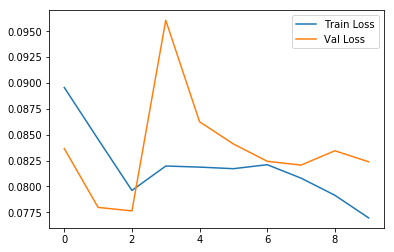

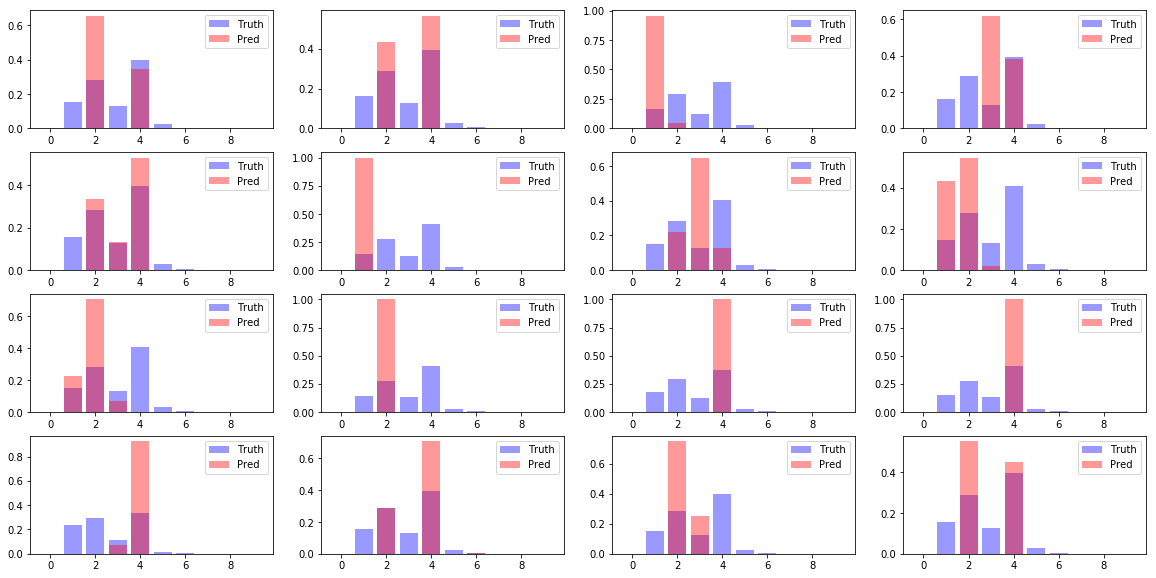

In [100]:
plot_loss(df_result)
plot_distribution(df_result, 16)
df_result['klDiv']

In [58]:
df_result.iloc[0]

atn                                                                     True
batch_size                                                               128
bn                                                                      True
clip                                                                    0.25
distribution_total         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
dropout                                                                  0.3
epoch                                                                     10
exp_name                                                              result
gamma                                                                    0.1
hidden_dim                                                               128
in_dim                                                                    59
klDiv                                                                    inf
l2_coef                                                                0.001

In [281]:
#yes logarithms in the output of the model & self kldiv

In [256]:
args.batch_size = 128
args.lr = 0.1
args.l2_coef = 0.001
args.optim = 'Adadelta'
args.epoch = 2
args.n_block = 2
args.n_layer = 2
args.n_atom = args.max_atoms
args.in_dim = args.num_feature
args.hidden_dim = 128
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = args.resolution
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 4
args.dropout = 0.3
args.step_size = 5
args.gamma = 0.1
args.clip = 0.25

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [257]:
list_lr = [1, 0.1, 0.001]
list_n_block = [1, 2, 3, 4]
var1 = "lr"
var2 = "n_block"

dict_result = dict()
n_iter = len(list_n_block)*len(list_lr)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for lr in list_lr:
    for n_block in list_n_block:
        args.lr = lr
        args.n_block = n_block
        args.exp_name = var1+':'+str(lr)+'/'+var2+':'+str(n_block)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('lr vs n_block 11000.JSON', orient='table')

lr:1/n_block:1 took 14seconds.
lr:1/n_block:2 took 24seconds.
lr:1/n_block:3 took 32seconds.
lr:1/n_block:4 took 40seconds.
lr:0.1/n_block:1 took 14seconds.
lr:0.1/n_block:2 took 24seconds.
lr:0.1/n_block:3 took 32seconds.
lr:0.1/n_block:4 took 40seconds.
lr:0.001/n_block:1 took 14seconds.
lr:0.001/n_block:2 took 24seconds.
lr:0.001/n_block:3 took 32seconds.
lr:0.001/n_block:4 took 40seconds.



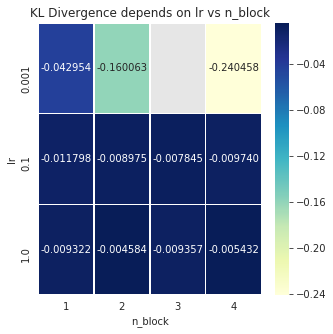

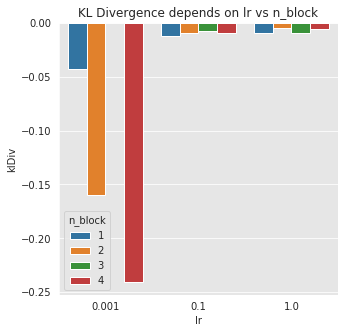

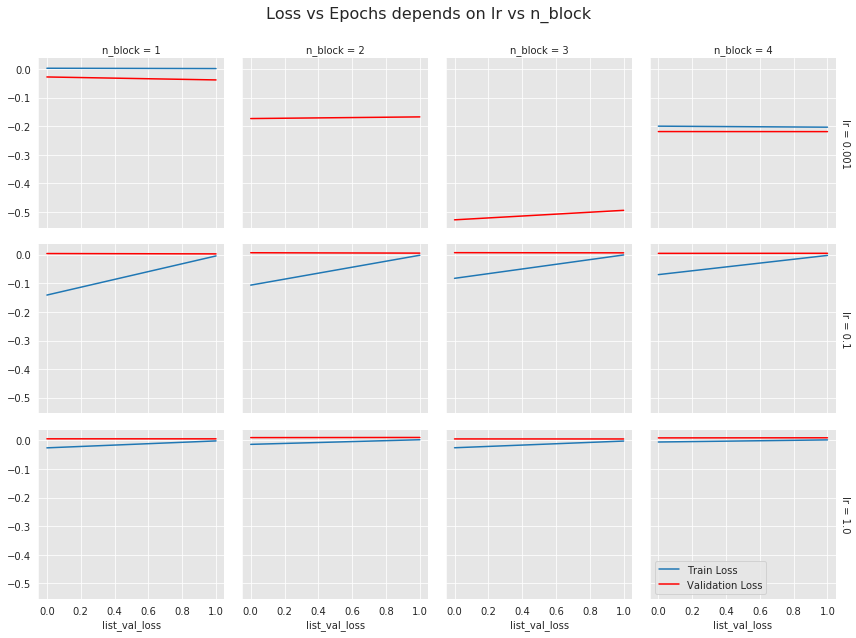

In [249]:
df_result = pd.read_json('lr vs n_block 11000.JSON', orient='table')

plot_performance_grid(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss_grid(df_result, var1, var2, 0.1)

In [287]:
#no logarithms in the output of the model & self kldiv

In [387]:
args.batch_size = 128
args.lr = 0.1
args.l2_coef = 0.001
args.optim = 'Adadelta'
args.epoch = 10
args.n_block = 2
args.n_layer = 2
args.n_atom = args.max_atoms
args.in_dim = args.num_feature
args.hidden_dim = 128
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = args.resolution
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 4
args.dropout = 0.3
args.step_size = 5
args.gamma = 0.1
args.clip = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [391]:
list_lr = [100, 10, 1, 0.1]
list_n_block = [1, 2, 3, 4]
var1 = "lr"
var2 = "n_block"

dict_result = dict()
n_iter = len(list_n_block)*len(list_lr)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for lr in list_lr:
    for n_block in list_n_block:
        args.lr = lr
        args.n_block = n_block
        args.exp_name = var1+':'+str(lr)+'/'+var2+':'+str(n_block)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('lr vs n_block 11000.JSON', orient='table')

lr:100/n_block:1 took 69seconds.
lr:100/n_block:2 took 119seconds.
lr:100/n_block:3 took 159seconds.
lr:100/n_block:4 took 199seconds.
lr:10/n_block:1 took 69seconds.
lr:10/n_block:2 took 119seconds.
lr:10/n_block:3 took 159seconds.
lr:10/n_block:4 took 199seconds.
lr:1/n_block:1 took 69seconds.
lr:1/n_block:2 took 119seconds.
lr:1/n_block:3 took 159seconds.
lr:1/n_block:4 took 199seconds.
lr:0.1/n_block:1 took 69seconds.
lr:0.1/n_block:2 took 119seconds.
lr:0.1/n_block:3 took 159seconds.
lr:0.1/n_block:4 took 199seconds.



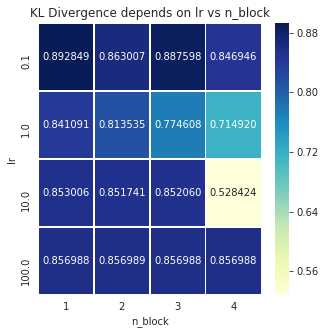

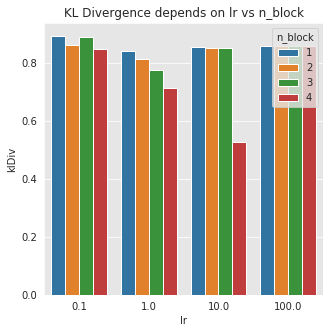

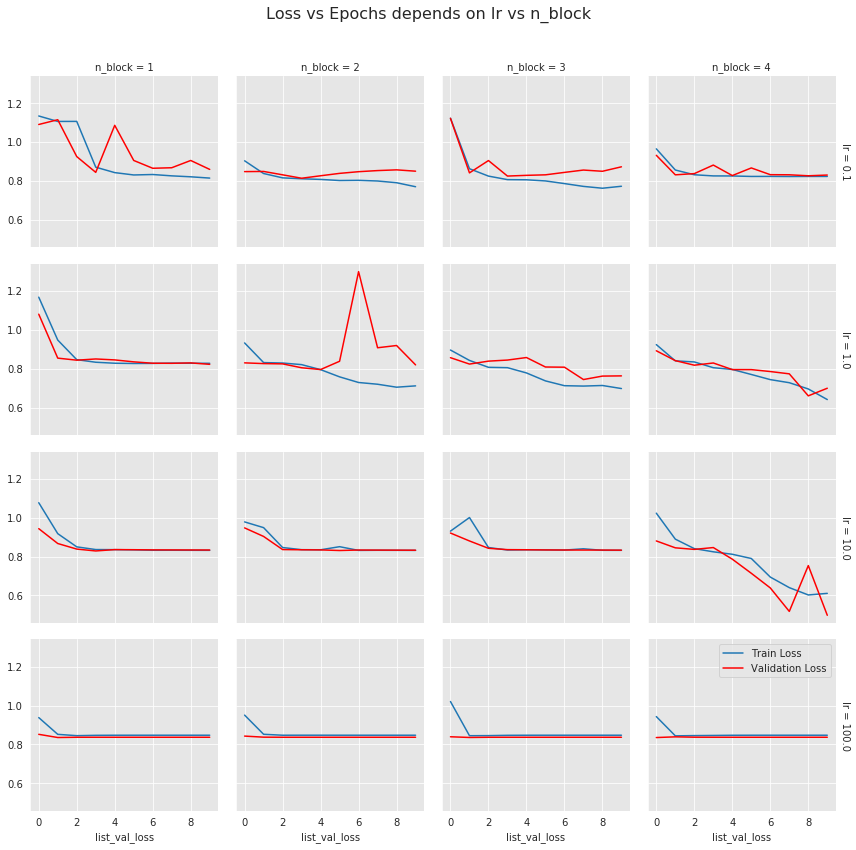

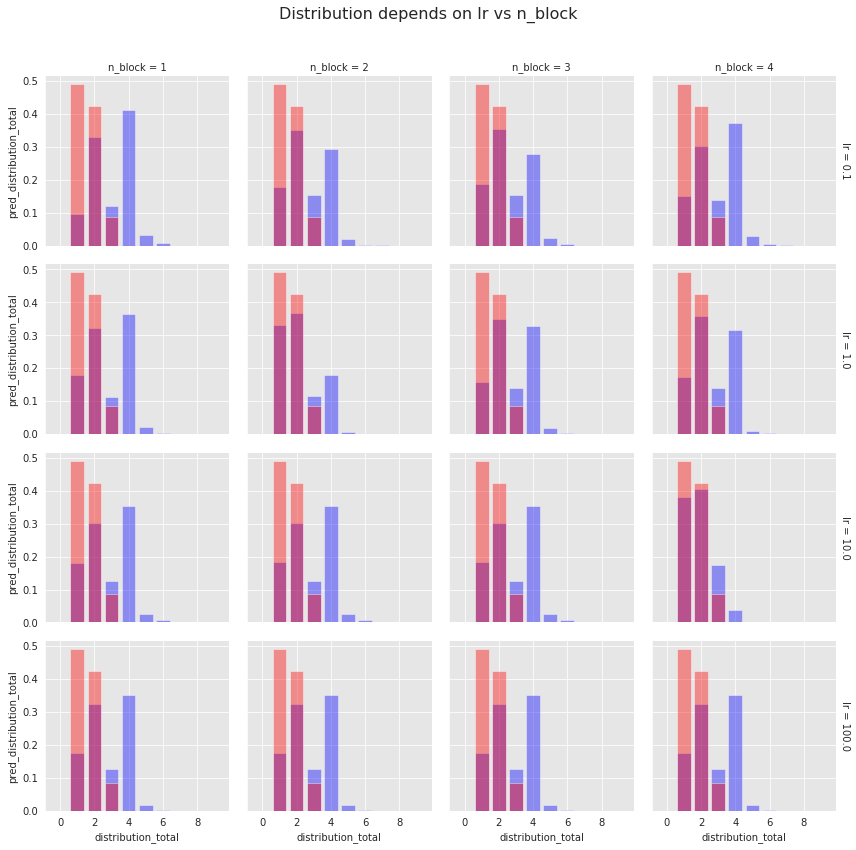

In [392]:
df_result = pd.read_json('lr vs n_block 11000.JSON', orient='table')

plot_performance_grid(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss_grid(df_result, var1, var2, 0.1)
plot_distribution_grid(df_result, var1, var2)

In [393]:
df_result['pred_distribution_total']

lr:100/n_block:1    [[0.0005022574, 0.1743104607, 0.3245642185, 0....
lr:100/n_block:2    [[0.0005023549, 0.1743088216, 0.3245635331, 0....
lr:100/n_block:3    [[0.0005022176, 0.17431139950000002, 0.3245643...
lr:100/n_block:4    [[0.0005019959000000001, 0.1743109971, 0.32456...
lr:10/n_block:1     [[0.0004870017, 0.18135805430000002, 0.3027298...
lr:10/n_block:2     [[0.0004615399, 0.1837518662, 0.3013161421, 0....
lr:10/n_block:3     [[0.0004762348, 0.1831296086, 0.3019768, 0.125...
lr:10/n_block:4     [[7.920000000000001e-08, 0.3864834607, 0.40701...
lr:1/n_block:1      [[4.45904e-05, 0.1847676188, 0.3302475512, 0.1...
lr:1/n_block:2      [[7.399280000000001e-05, 0.3367239535, 0.28528...
lr:1/n_block:3      [[3.26219e-05, 0.245473668, 0.4064053297000000...
lr:1/n_block:4      [[9.919400000000001e-05, 0.18247896430000002, ...
lr:0.1/n_block:1    [[0.0001388499, 0.09749604020000001, 0.3306122...
lr:0.1/n_block:2    [[0.0003992018, 0.1773051172, 0.35092741250000...
lr:0.1/n_block:3    

In [292]:
#yes logarithms in the output of the model & torch kldiv

In [31]:
args.batch_size = 128
args.lr = 10
args.l2_coef = 0.001
args.optim = 'Adadelta'
args.epoch = 10
args.n_block = 4
args.n_layer = 2
args.n_atom = args.max_atoms
args.in_dim = args.num_feature
args.hidden_dim = 128
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = args.resolution
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 4
args.dropout = 0.3
args.step_size = 5
args.gamma = 0.1
args.clip = 0.25

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [32]:
list_n_layer = [1, 2, 3]
list_hidden_dim = [64, 128, 256]
var1 = "n_layer"
var2 = "hidden_dim"

dict_result = dict()
n_iter = len(list_n_layer)*len(list_hidden_dim)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for n_layer in list_n_layer:
    for hidden_dim in list_hidden_dim:
        args.n_layer = n_layer
        args.hidden_dim = hidden_dim
        args.exp_name = var1+':'+str(n_layer)+'/'+var2+':'+str(hidden_dim)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('n_layer vs hidden_dim 11000.JSON', orient='table')

n_layer:1/hidden_dim:64 took 117seconds.
n_layer:1/hidden_dim:128 took 139seconds.
n_layer:1/hidden_dim:256 took 184seconds.
n_layer:2/hidden_dim:64 took 176seconds.
n_layer:2/hidden_dim:128 took 210seconds.
n_layer:2/hidden_dim:256 took 281seconds.
n_layer:3/hidden_dim:64 took 234seconds.
n_layer:3/hidden_dim:128 took 281seconds.
n_layer:3/hidden_dim:256 took 377seconds.



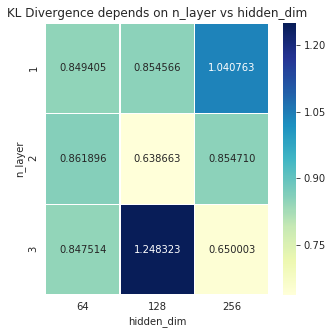

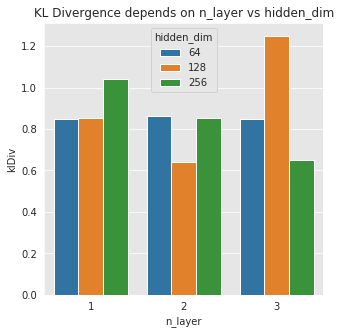

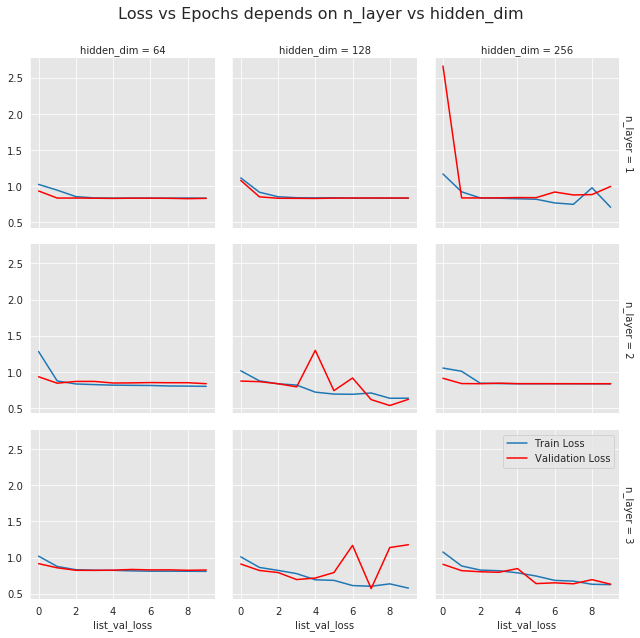

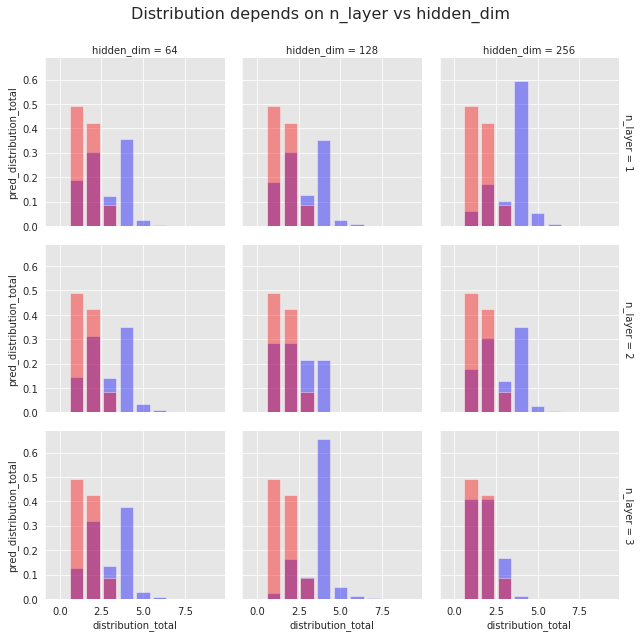

In [367]:
df_result = pd.read_json('n_layer vs hidden_dim 11000.JSON', orient='table')

plot_performance_grid(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss_grid(df_result, var1, var2, 0.1)
plot_distribution_grid(df_result, var1, var2)

In [ ]:
#no logarithms in the output of the model & use torch kldiv

In [34]:
args.batch_size = 128
args.lr = 10
args.l2_coef = 0.001
args.optim = 'Adadelta'
args.epoch = 10
args.n_block = 4
args.n_layer = 3
args.n_atom = args.max_atoms
args.in_dim = args.num_feature
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = args.resolution
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 4
args.dropout = 0.3
args.step_size = 5
args.gamma = 0.1
args.clip = 0.25

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [35]:
list_num_head = [1, 2, 4]
list_pred_dim1 = [128, 256, 512]
var1 = "num_head"
var2 = "pred_dim1"

dict_result = dict()
n_iter = len(list_num_head)*len(list_pred_dim1)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for num_head in list_num_head:
    for pred_dim1 in list_pred_dim1:
        args.num_head = num_head
        args.pred_dim1 = pred_dim1
        args.exp_name = var1+':'+str(num_head)+'/'+var2+':'+str(pred_dim1)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('list_num_head vs pred_dim1 11000.JSON', orient='table')

num_head:1/pred_dim1:128 took 269seconds.
num_head:1/pred_dim1:256 took 270seconds.
num_head:1/pred_dim1:512 took 273seconds.
num_head:2/pred_dim1:128 took 301seconds.
num_head:2/pred_dim1:256 took 302seconds.
num_head:2/pred_dim1:512 took 304seconds.
num_head:4/pred_dim1:128 took 378seconds.
num_head:4/pred_dim1:256 took 379seconds.
num_head:4/pred_dim1:512 took 381seconds.



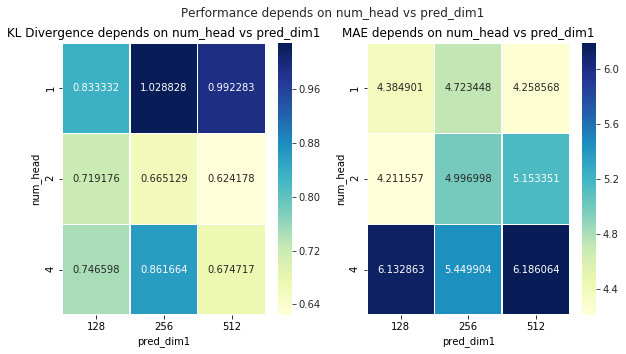

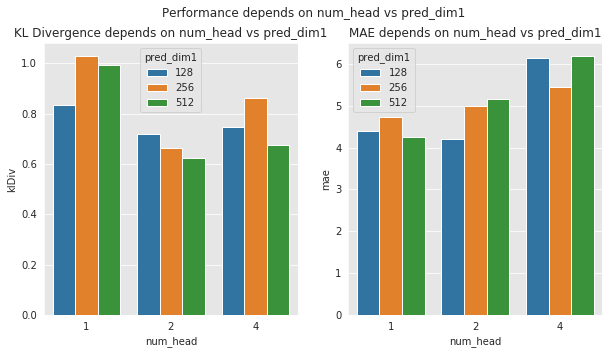

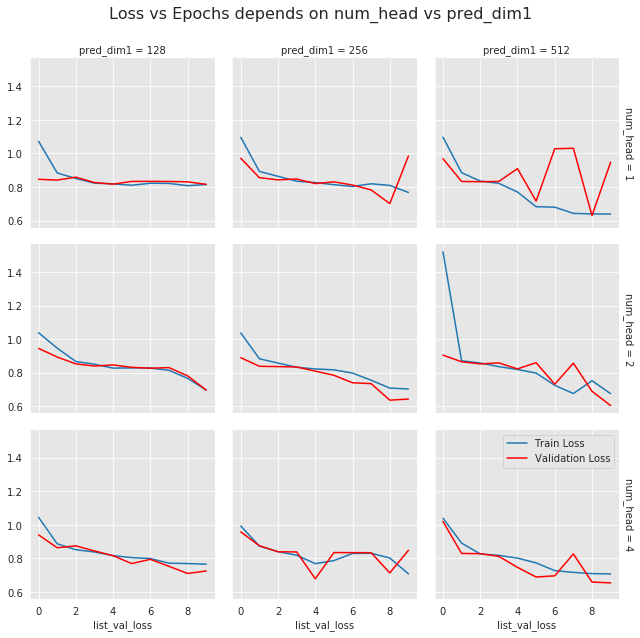

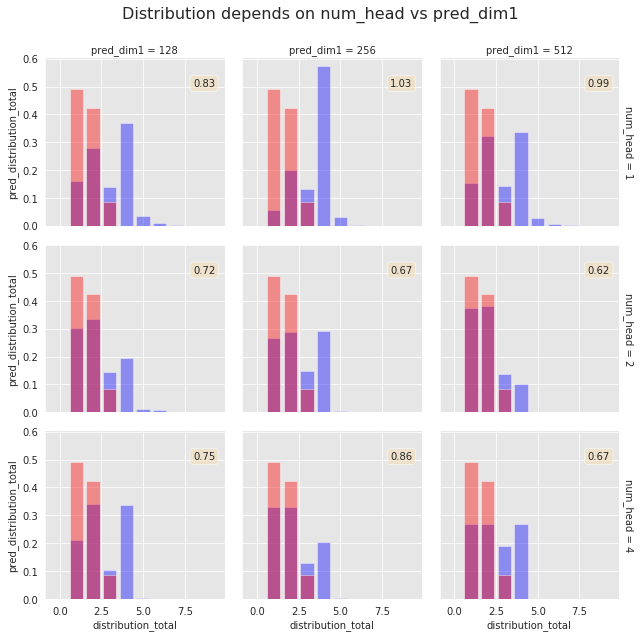

In [36]:
df_result = pd.read_json('list_num_head vs pred_dim1 11000.JSON', orient='table')

plot_performance_grid(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss_grid(df_result, var1, var2, 0.1)
plot_distribution_grid(df_result, var1, var2)

In [40]:
args.batch_size = 128
args.lr = 10
args.l2_coef = 0.001
args.optim = 'Adadelta'
args.epoch = 10
args.n_block = 4
args.n_layer = 3
args.n_atom = args.max_atoms
args.in_dim = args.num_feature
args.hidden_dim = 256
args.pred_dim1 = 512
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = args.resolution
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 2
args.dropout = 0.3
args.step_size = 5
args.gamma = 0.1
args.clip = 0.25

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [41]:
list_pred_dim2 = [128, 256, 512]
list_pred_dim3 = [128, 256, 512]
var1 = "pred_dim2"
var2 = "pred_dim3"

dict_result = dict()
n_iter = len(list_pred_dim2)*len(list_pred_dim3)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for pred_dim2 in list_pred_dim2:
    for pred_dim3 in list_pred_dim3:
        args.pred_dim2 = pred_dim2
        args.pred_dim3 = pred_dim3
        args.exp_name = var1+':'+str(pred_dim2)+'/'+var2+':'+str(pred_dim3)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('pred_dim2 vs pred_dim3 11000.JSON', orient='table')

pred_dim2:128/pred_dim3:128 took 303seconds.
pred_dim2:128/pred_dim3:256 took 303seconds.
pred_dim2:128/pred_dim3:512 took 304seconds.
pred_dim2:256/pred_dim3:128 took 304seconds.
pred_dim2:256/pred_dim3:256 took 304seconds.
pred_dim2:256/pred_dim3:512 took 303seconds.
pred_dim2:512/pred_dim3:128 took 305seconds.
pred_dim2:512/pred_dim3:256 took 306seconds.
pred_dim2:512/pred_dim3:512 took 304seconds.



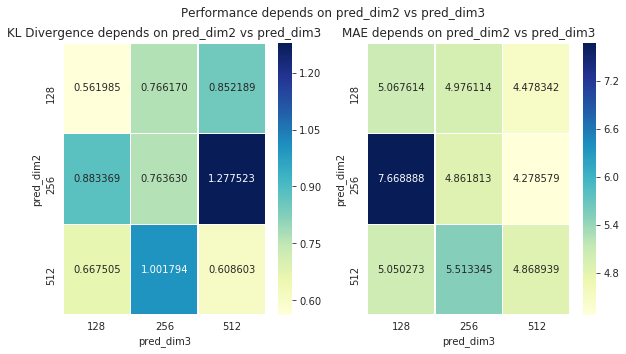

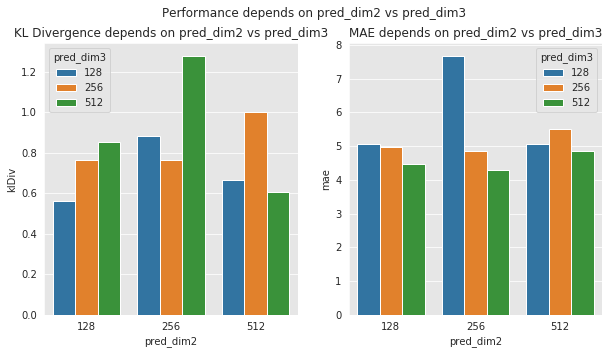

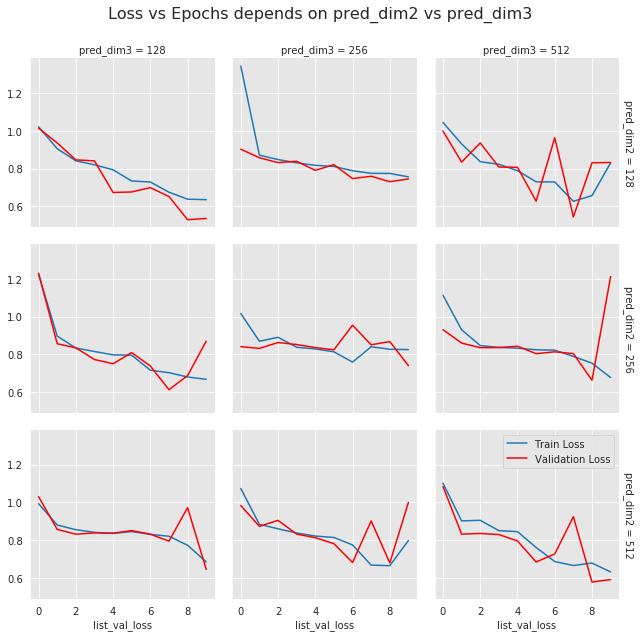

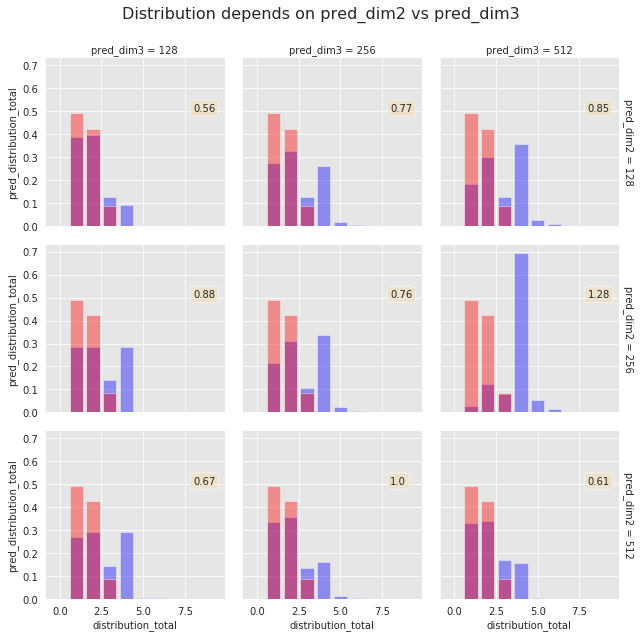

In [42]:
df_result = pd.read_json('pred_dim2 vs pred_dim3 11000.JSON', orient='table')

plot_performance_grid(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss_grid(df_result, var1, var2, 0.1)
plot_distribution_grid(df_result, var1, var2)

In [43]:
args.batch_size = 128
args.lr = 10
args.l2_coef = 0.001
args.optim = 'Adadelta'
args.epoch = 10
args.n_block = 4
args.n_layer = 3
args.n_atom = args.max_atoms
args.in_dim = args.num_feature
args.hidden_dim = 256
args.pred_dim1 = 512
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = args.resolution
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 2
args.dropout = 0.3
args.step_size = 5
args.gamma = 0.1
args.clip = 0.25

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [44]:
list_l2_coef = [0.1, 0.001, 0.0001, 0.00001, 0.000001]
list_dropout = [0, 0.1, 0.2, 0.3, 0.4]
var1 = "l2_coef"
var2 = "dropout"

dict_result = dict()
n_iter = len(list_l2_coef)*len(list_dropout)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for l2_coef in list_l2_coef:
    for dropout in list_dropout:
        args.l2_coef = l2_coef
        args.dropout = dropout
        args.exp_name = var1+':'+str(l2_coef)+'/'+var2+':'+str(dropout)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('l2_coef vs dropout 11000.JSON', orient='table')

l2_coef:0.1/dropout:0 took 294seconds.
l2_coef:0.1/dropout:0.1 took 303seconds.
l2_coef:0.1/dropout:0.2 took 303seconds.
l2_coef:0.1/dropout:0.3 took 304seconds.
l2_coef:0.1/dropout:0.4 took 304seconds.
l2_coef:0.001/dropout:0 took 297seconds.
l2_coef:0.001/dropout:0.1 took 306seconds.
l2_coef:0.001/dropout:0.2 took 305seconds.
l2_coef:0.001/dropout:0.3 took 306seconds.
l2_coef:0.001/dropout:0.4 took 305seconds.
l2_coef:0.0001/dropout:0 took 297seconds.
l2_coef:0.0001/dropout:0.1 took 305seconds.
l2_coef:0.0001/dropout:0.2 took 306seconds.
l2_coef:0.0001/dropout:0.3 took 306seconds.
l2_coef:0.0001/dropout:0.4 took 306seconds.
l2_coef:1e-05/dropout:0 took 297seconds.
l2_coef:1e-05/dropout:0.1 took 304seconds.
l2_coef:1e-05/dropout:0.2 took 307seconds.
l2_coef:1e-05/dropout:0.3 took 307seconds.
l2_coef:1e-05/dropout:0.4 took 305seconds.
l2_coef:1e-06/dropout:0 took 297seconds.
l2_coef:1e-06/dropout:0.1 took 307seconds.
l2_coef:1e-06/dropout:0.2 took 306seconds.
l2_coef:1e-06/dropout:0.3 

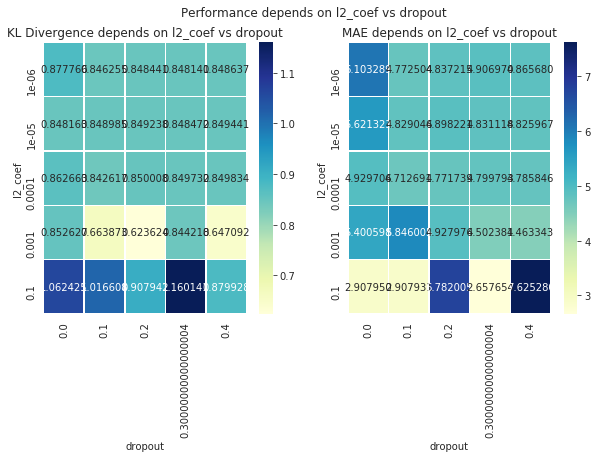

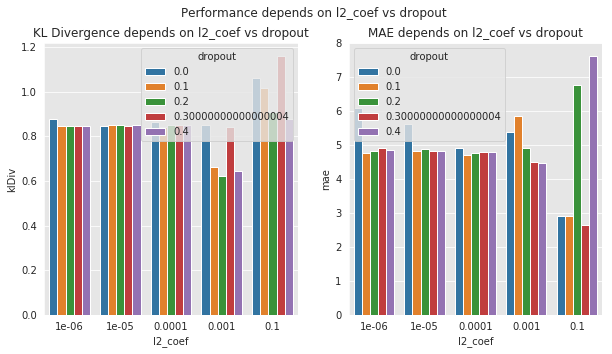

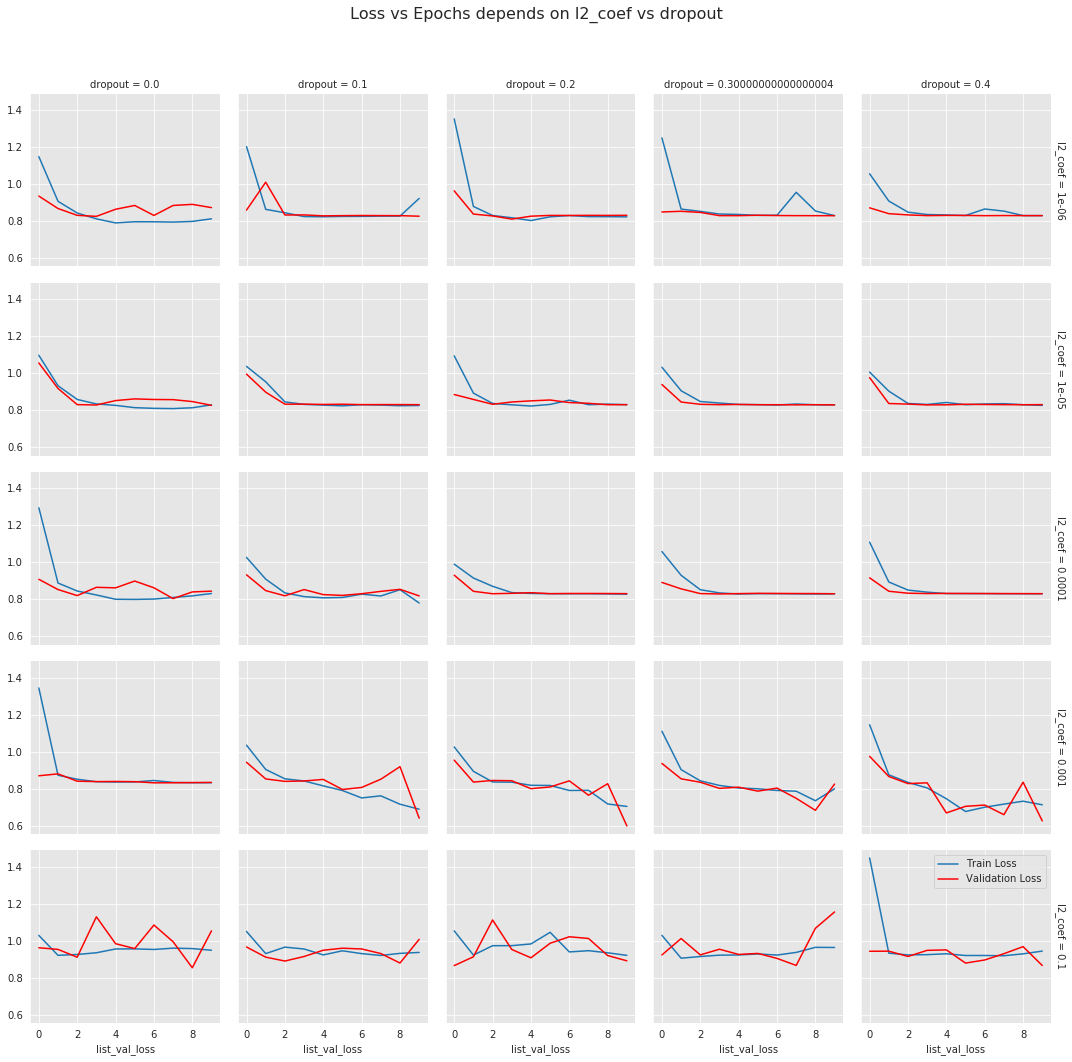

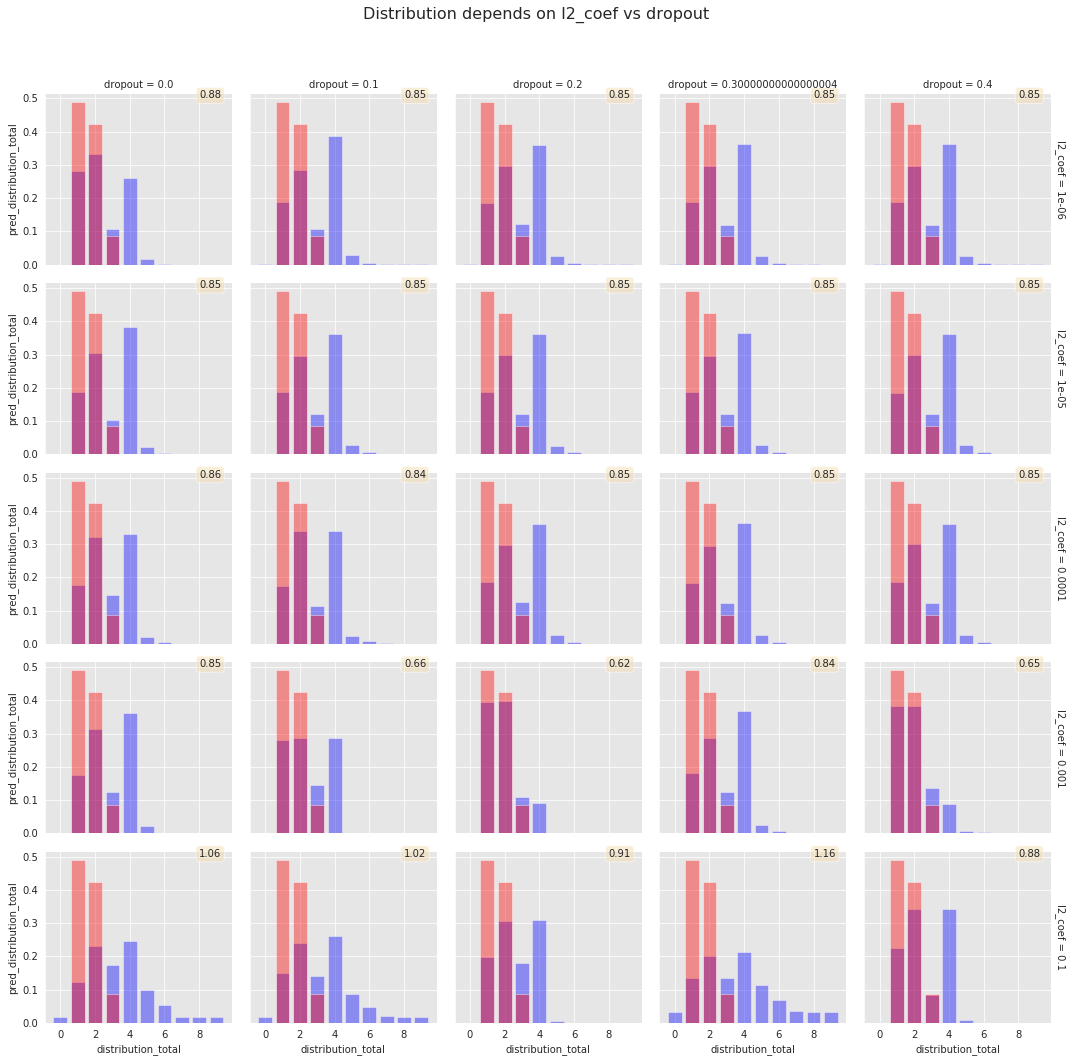

In [45]:
df_result = pd.read_json('l2_coef vs dropout 11000.JSON', orient='table')

plot_performance_grid(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss_grid(df_result, var1, var2, 0.1)
plot_distribution_grid(df_result, var1, var2)

In [43]:
args.batch_size = 128
args.lr = 10
args.l2_coef = 0.001
args.optim = 'Adadelta'
args.epoch = 10
args.n_block = 4
args.n_layer = 3
args.n_atom = args.max_atoms
args.in_dim = args.num_feature
args.hidden_dim = 256
args.pred_dim1 = 512
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = args.resolution
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 2
args.dropout = 0.2
args.step_size = 5
args.gamma = 0.1
args.clip = 0.25

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [44]:
dict_result = dict()
n_iter = args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "result final 11000 10"
result = vars(experiment(dict_partition, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('result final 11000 10.JSON', orient='table')

[1043, 100, 977, 173, 332, 920, 345, 61, 267, 209, 877, 377, 406, 826, 899, 207, 1069, 92, 461, 452, 742, 970, 916, 1023, 624, 903, 1079, 561, 1000, 695, 567, 477, 330, 76, 69] [0.0175113063, 0.0435741246, 0.0634249598, 0.0809090286, 0.0863893703, 0.087716952, 0.0911333933, 0.0959892571, 0.0982151628, 0.09825236350000001, 0.0986108631, 0.1001679674, 0.1007233262, 0.1010150239, 0.1048171222, 0.1070561931, 0.1075621247, 0.1089446694, 0.1097144783, 0.11204110090000001, 0.11218287800000001, 0.1127191186, 0.11598482730000001, 0.1166001111, 0.11963786180000001, 0.11967223140000001, 0.1206220984, 0.1238689721, 0.1264223456, 0.1285390407, 0.12892694770000002, 0.1305806339, 0.1317169815, 0.1320275068, 0.13215646150000002]


result final 11000 10    4.992567
Name: mae, dtype: float64

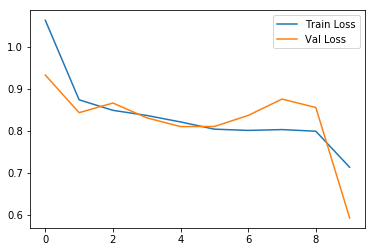

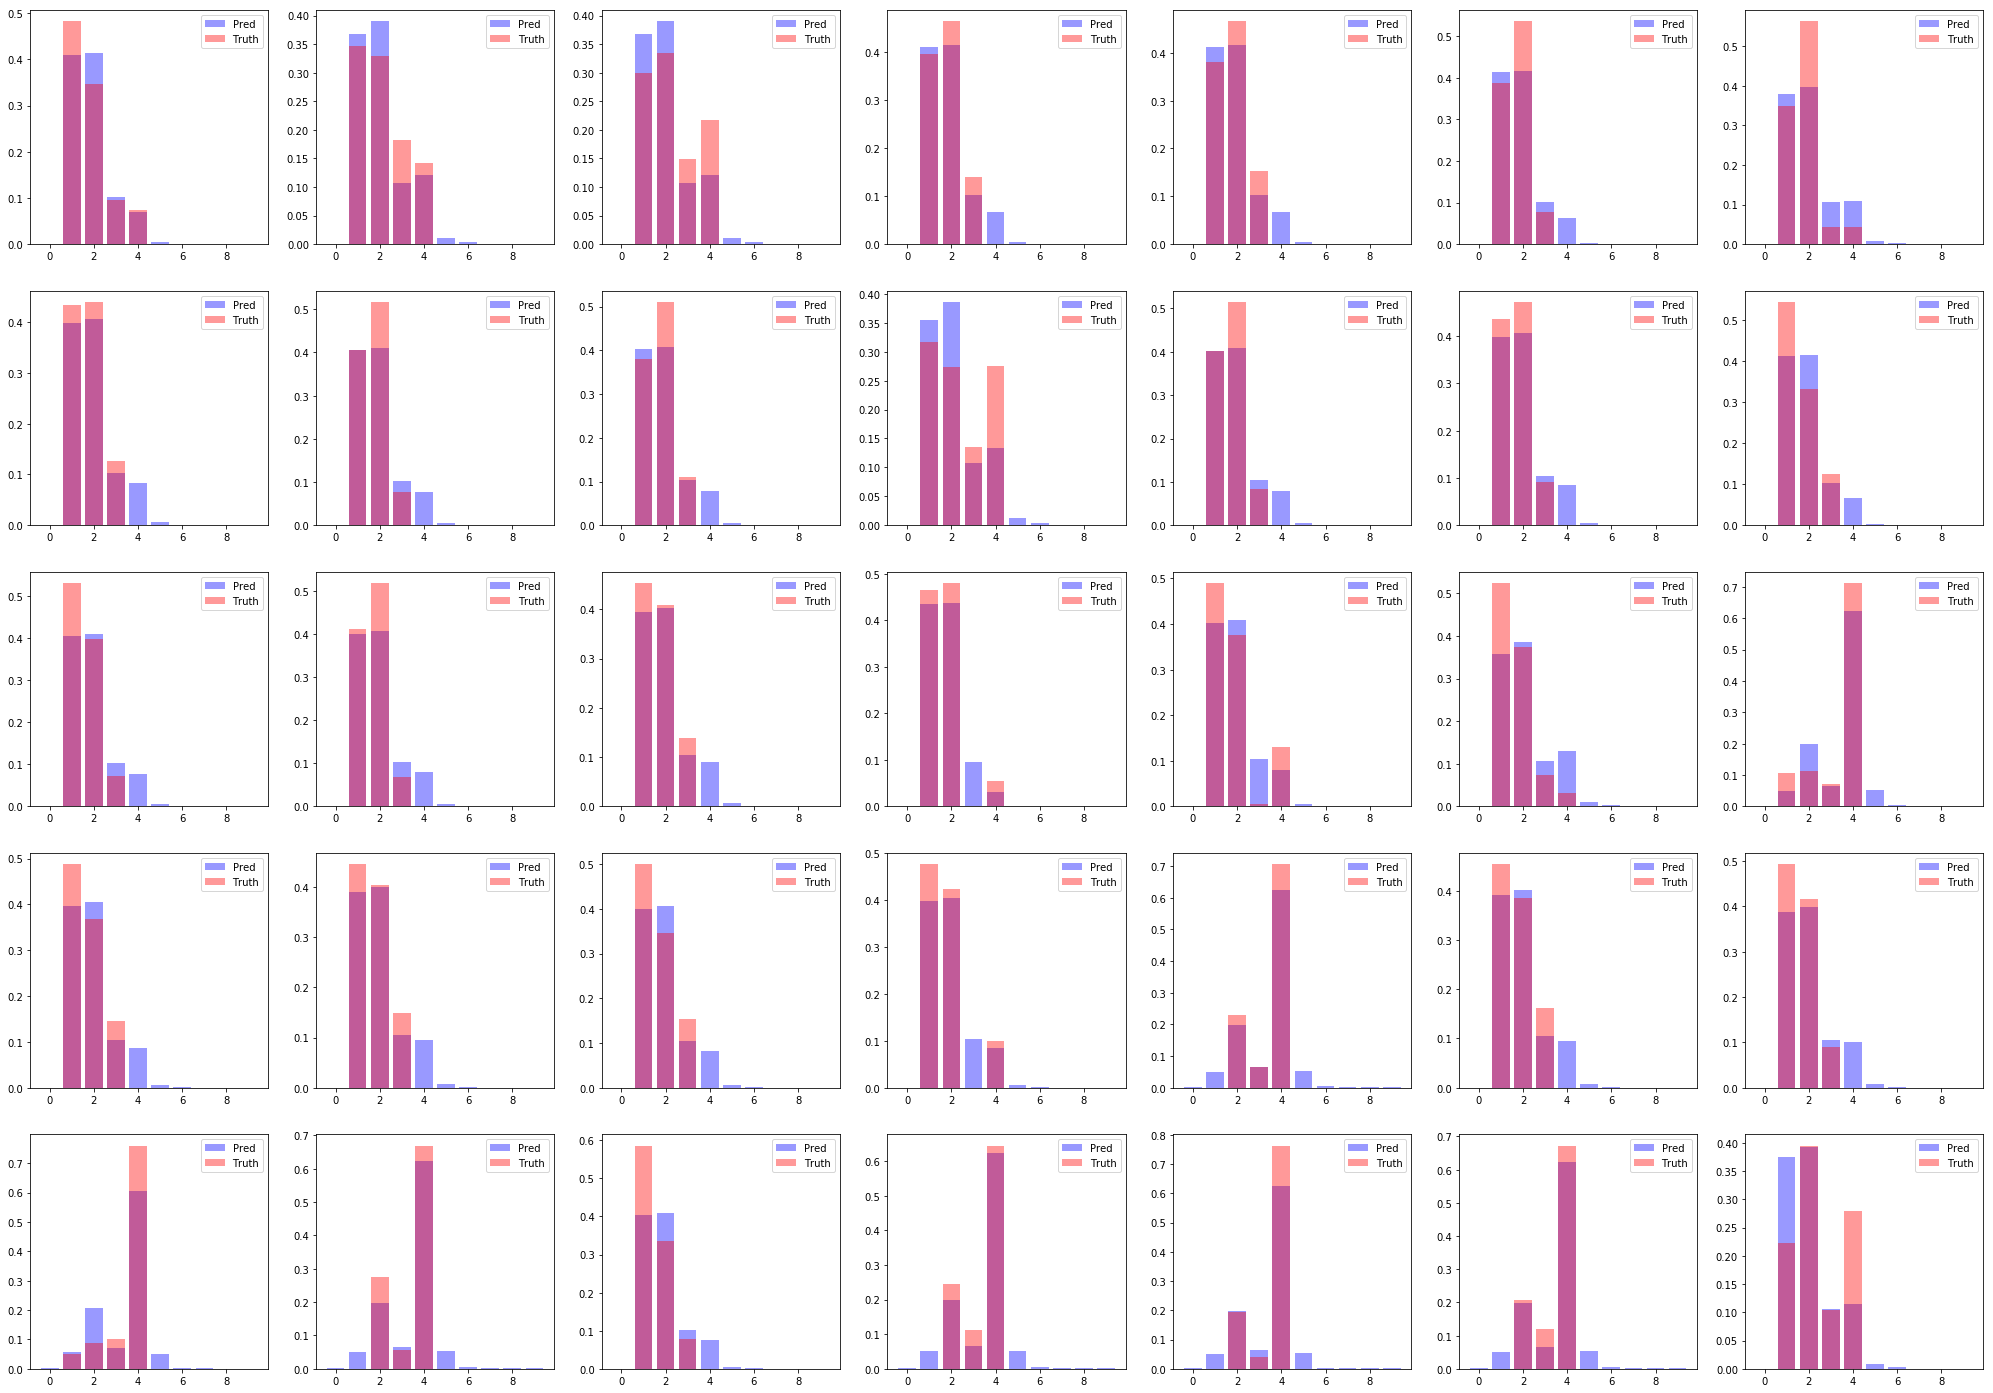

In [69]:
df_result = pd.read_json('result final 11000 10.JSON', orient='table')

plot_loss(df_result)
plot_distribution(df_result, 5, 7, sort='best')
df_result['klDiv']
df_result['mae']

In [215]:
inputs = torch.tensor([0.333, 0.333, 0.333])
targets = torch.tensor([0.36, 0.48, 0.16])
inputs = torch.log(inputs)

In [216]:
klDiv(inputs, targets)

tensor(0.0288)

In [34]:
#input = Q, target = P
inputs = torch.tensor([0.36, 0.48, 0.16])
targets = torch.tensor([0.333, 0.333, 0.333])
inputs = torch.log(inputs)

In [37]:
mae = mean_absolute_error(inputs, targets)
float(mae)

1.5290673971176147

In [237]:
myKLDivLoss(inputs, targets)

tensor(0.0321)

In [238]:
#input = Q, target = P
inputs = torch.tensor([0.1, 0.2, 0.3, 0.4])
targets = torch.tensor([0.1, 0.2,0.4, 0.3])
inputs = torch.log(inputs)

In [239]:
klDiv(inputs, targets)

tensor(0.0072)

In [240]:
myKLDivLoss(inputs, targets)

tensor(0.0072)